---
title: Implementing Logistic Regression
author: Caitlin Baxter
date: '2023-03-31'
description: "Implementing logistic regression"
format: html
---

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression
from logistic import GradientDescentOptimizer
from matplotlib import pyplot as plt
import torch

## Logistic Regression Implementation

Here is the link to my [logistic regression implementation](https://github.com/cbbaxter/cbbaxter.github.io/blob/b84f551fa2a1e121843992dfbee7bba17b92bd46/posts/implementing-logistic-regression/logistic.py)

## Abstract
In this blog post I implemented the logistic regression algorithm to classify data. It was demonstrated through experimentation that the algorithm will terminate with a loss of zero on linearly seperable data. When the momentum is increased (beta) it will converge at a lower loss more quickly than when the loss is smaller. It was also determined that the logistic regression algorithm is at risk of overfitting, particularly on data with an abundance of features. 

In [2]:
torch.manual_seed(123)

def classification_data(n_points, noise, p_dims):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# Code modifies from Prof. Chodrow's "plot perceptron data"
def plot_logistic_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# Code by Prof. Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)



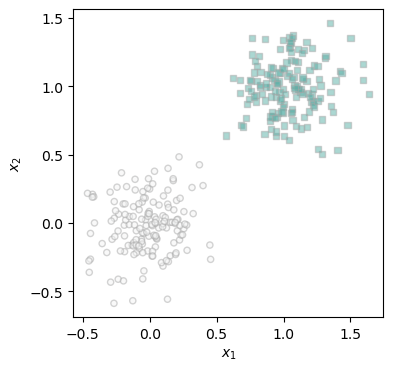

In [3]:
X, y = classification_data(300, 0.2, p_dims = 2)

fig, ax = plt.subplots(1, 1, figsize= (4, 4))
plot_logistic_data(X, y, ax)

In these chuncks of code, written by Professor Chodrow, functions are created for the creation and plotting of data. This plot shows the data generated with minimal noise indicating that it is linearly seperable as we could clearly seperate the two groups by a straight line. 

## Experiment 1: Vanilla Gradient Decsent

With only two dimensions, a sufficiently small learning rate, and a momentum of 0, gradient descent for logistic regression will converge to a weight vector that looks visually correct when plotted as a linear decision boundary between the two clumps of data. To begin this experiment, I generated 300 data points with minimal noise and 2 dimensions. The logistic regression is initialized with a learning rate of 0.1 and a momentum of 0.

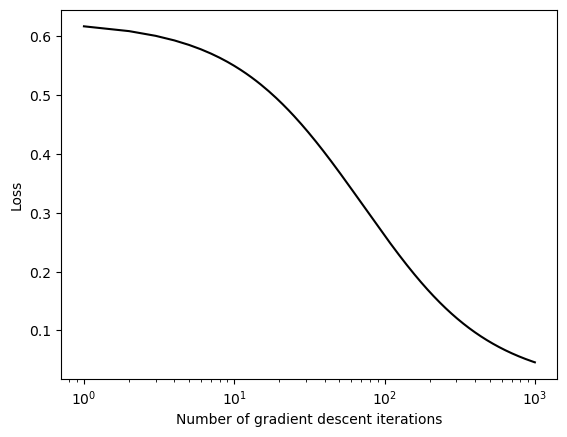

In [4]:
## Vanilla gradient descent
torch.manual_seed(123)

X, y = classification_data(300, 0.2, p_dims = 2)

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []
alpha = 0.1 # sufficiently small
beta = 0
max_iter = 1000
curr_iter = 0

loss = LR.loss(X, y) 

while curr_iter < max_iter and loss > 0:

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    opt.step(X, y, alpha, beta)
    
    curr_iter += 1

    if curr_iter == max_iter:
        final_w = torch.clone(LR.w)



plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss")



As seen in this plot, the loss decreases monotonically over the gradient descent iterations.

(-2.0, 4.0)

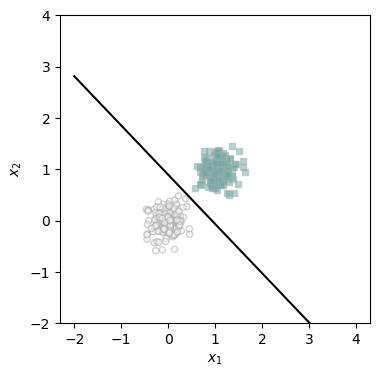

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_logistic_data(X, y, ax)
draw_line(final_w, x_min = -2, x_max = 4, ax = ax, color = "black")
ax.set_ylim(-2, 4)

When plotted with the data, we can see that the final weight vector that the logistic regression algorithm converged on weight that corresponds with a correct classification line.

## Benefits of Momentum

In order to access the benefits of momentum, we initialize a logistic regression model with the same learning rate but a momentum that has been increased to 0.9.

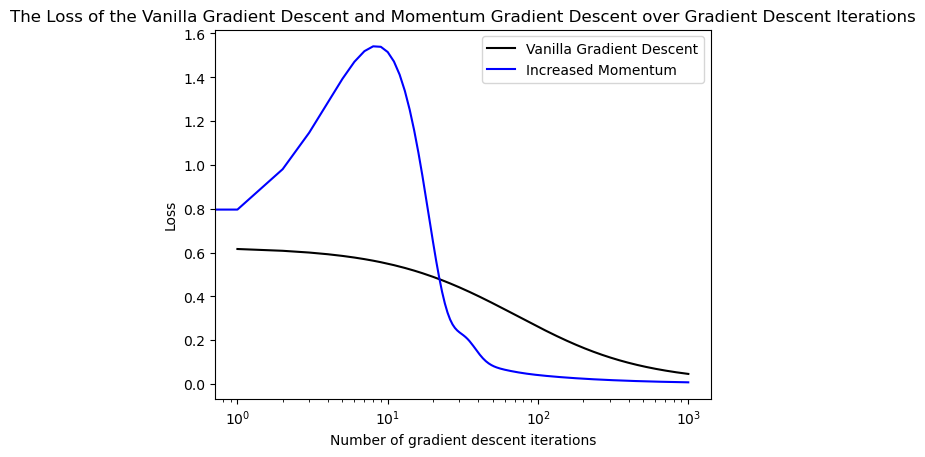

In [6]:
# Benefits of Momentum

torch.manual_seed(123)

X, y = classification_data(300, 0.2, p_dims = 2)

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec_mom = []
alpha = 0.1 # sufficiently small
beta = 0.9
max_iter = 1000
curr_iter = 0

loss = LR.loss(X, y) 

while curr_iter < max_iter and loss > 0:

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec_mom.append(loss)

    # only this line actually changes the parameter value
    # The whole definition is: 
    # self.model.w -= lr*self.model.grad(X, y)

    opt.step(X, y, alpha, beta)
    
    curr_iter += 1

    if curr_iter == max_iter:
        final_w = torch.clone(LR.w)



plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black", label = "Vanilla Gradient Descent") 
plt.plot(loss_vec_mom,  label = "Increased Momentum", color = "blue")
plt.semilogx()
plt.legend()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss", title = "The Loss of the Vanilla Gradient Descent and Momentum Gradient Descent over Gradient Descent Iterations")




In this plot we can see that the loss has decreased much faster in the gradient descent with the higher momentum than it did during Vanilla Gradient Descent.

## Overfitting

In order to see how susceptible the model is to overfitting, we generate some random synthetic data, with 20 observations and 40 features. While the accuracy on the training data is less than 100%, random test and train data continues to be generated, training a model through gradient descent each time. 

When we evaluate the model we see that it achieves an accuracy of 100% on the training data, but only 85% on the testing data. This shows that under certain circumstances, the model can be overfit to the training data, inhibiting its ability to generalize to different data sets.

Training accuracy:  tensor(1.)
Testing accuracy:  tensor(0.8500)


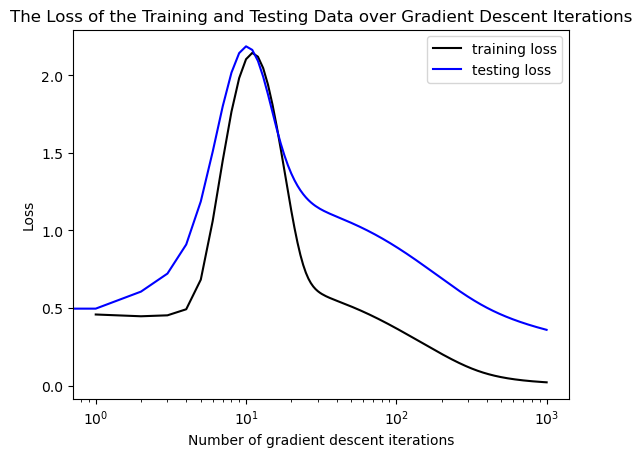

In [7]:
torch.manual_seed(123)


LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

alpha = 0.01 # sufficiently small
beta = 0.8
max_iter = 1000

n = 20
p = 40

train_acc = 0.0
test_acc = 0.0
loss_vec_train = []
loss = 1.0

while train_acc != 1.0:
    LR.w = None
    loss_vec1 = []
    loss_vec2 = []
    test_acc_vec = []
    train_acc_vec = []
    curr_iter = 0
    X_train, y_train = classification_data(n, 0.3, p_dims = p)
    X_test, y_test = classification_data(n, 0.3, p_dims = p)
    loss_tr = LR.loss(X_train, y_train) 
    loss_ts = LR.loss(X_test, y_test)

    while curr_iter < max_iter and loss_tr > 0:
        loss_tr = LR.loss(X_train, y_train)
        loss_ts = LR.loss(X_test, y_test)
        loss_vec1.append(loss_tr)
        loss_vec2.append(loss_ts)
        opt.step(X_train, y_train, alpha, beta)

        curr_iter += 1

        preds_train = LR.predict(X_train)
        train_score = torch.where(preds_train == y_train, 1.0, 0.0).mean()
        train_acc = train_score.mean()
    
        preds_test = LR.predict(X_test)
        test_score = torch.where(preds_test == y_test, 1.0, 0.0)
        test_acc = test_score.mean()

        test_acc_vec.append(test_acc)
        train_acc_vec.append(train_acc)

        if curr_iter == max_iter:
            final_w_train = torch.clone(LR.w)

    loss_vec_train = loss_vec1
    loss_vec_test = loss_vec2
    

print("Training accuracy: ", train_acc)
print("Testing accuracy: ", test_acc)

plt.plot(torch.arange(1, len(loss_vec_train)+1), loss_vec_train, color = "black", label="training loss") 
plt.plot(loss_vec_test, color = "blue", label="testing loss")
plt.semilogx()
plt.legend()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss", title = "The Loss of the Training and Testing Data over Gradient Descent Iterations")

## Plot the accuracy




As seen in this plot the loss of the testing function remains higher than the training loss for most of the iterations and is substancially higher when the maximum number of iterations is reached.

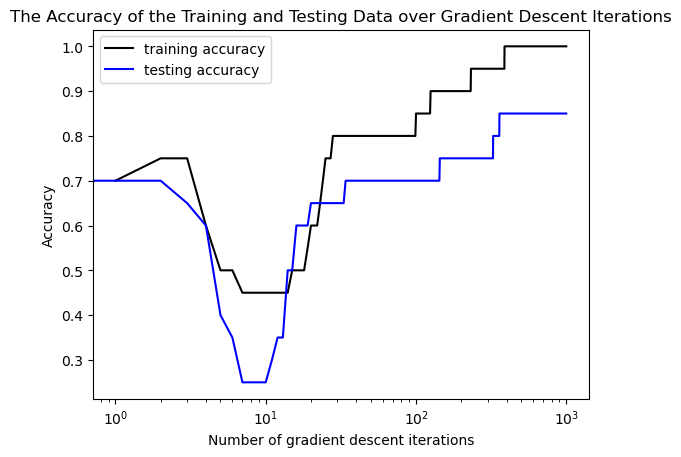

In [8]:
plt.plot(torch.arange(1, len(train_acc_vec)+1), train_acc_vec, label="training accuracy",color = "black") 
plt.plot(test_acc_vec, color = "blue", label="testing accuracy")
plt.semilogx()
plt.legend()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Accuracy", title = "The Accuracy of the Training and Testing Data over Gradient Descent Iterations")

The evidence of overfitting is more clearly visible in this graph where we can see the accuracy of the classification based on the weight vector for each iteration. As we can see, the training accuracy is quite a bit higher than the accuracy of the model on the training data, suggesting that the model was overfit on the training data specifications.

## Discussion

Through experimenting with different implementations of Logistic Regression we have been able to investigate how the model works. We determined that by increasing the momentum, the rate at which the gradient descent converged on a lower loss increased. We also showed that this logistic regression model is susceptible to overfitting by examining how it worked on data with a large number of features and observing that its performance was better and more accurate on the training data as opposed to the testing set.